<a href="https://colab.research.google.com/github/Mateusz-best-creator/Custom_TrainingLoop_Layers_Metrics/blob/main/Tensorflow_Advanced_Techniques_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [225]:
from sklearn.model_selection import train_test_split

(X_full, y_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.1, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((54000, 28, 28), (6000, 28, 28), (10000, 28, 28), (54000,), (6000,), (10000,))

In [226]:
# # For now let's use small chunks of our dataset

# X_train = X_train[:10000]
# y_train = y_train[:10000]
# X_valid = X_valid[:4000]
# y_valid = y_valid[:4000]
# X_test = X_test[:2000]
# y_test = y_test[:2000]

In [227]:
def create_dataset(x, y, train_set=False, batch_size=32):
  dataset = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                tf.constant(y)))
  if train_set:
    return dataset.shuffle(buffer_size=10_000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [228]:
# Get training, validation and test datasets
train_set = create_dataset(X_train, y_train, train_set=True)
valid_set = create_dataset(X_valid, y_valid)
test_set = create_dataset(X_test, y_test)

train_set, valid_set, test_set

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>)

## Create model architecture

In [229]:
# Now let's create our custom dense layer
class MyDense(tf.keras.layers.Layer):
  def __init__(self, units, activation=None, **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    self.kernel = self.add_weight("kernel", shape=[input_shape[-1], self.units],
                                  initializer="glorot_normal", dtype=tf.float32)
    self.bias = self.add_weight("bias", shape=[self.units],
                                initializer="zeros", dtype=tf.float32)

  def call(self, inputs):
    return self.activation(inputs @ self.kernel + self.bias)

In [230]:
# We will also add data augmentation to our model architecture
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2)
])

data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Rescaling(scale=1./255)
])

classifier_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding="same",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same",
                           activation="relu"),
    tf.keras.layers.Conv2D(64, 3, padding="same",
                           activation="relu"),
    tf.keras.layers.GlobalMaxPooling2D(),
    MyDense(10, activation="softmax")
])

# Construct final model
model = tf.keras.Sequential([
    data_preprocessing,
    data_augmentation,
    classifier_model
])

model

## Creating custom training loop

In [231]:
# Define parameters
n_epochs = 10

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

# Define train and validation metrics
train_metric = tf.keras.metrics.SparseCategoricalAccuracy()
valid_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [232]:
def apply_gradients(model, x, y, loss_func, optimizer):
  """
  We are going to call this function when preprocessing each training batch.
  """
  with tf.GradientTape() as tape:

    # Make predictions during forward pass
    logits = model(x)

    # Calculate loss
    loss = loss_func(y, logits)

  # Calculate the gradients
  gradients = tape.gradient(loss, model.trainable_variables)

  # Perform gradient descent step
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Return loss and logits
  return loss, logits

In [233]:
from tqdm import tqdm

In [234]:
def train_one_epoch(model, train_data, loss_func, optimizer):
  """
  Trains our model for one epoch.
  """
  # We will track of training and validation losses
  train_losses = []
  valid_losses = []

  pbar = tqdm(total=len(list(enumerate(train_set))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')

  # Loop through each batch in our dataset
  for step, (X_batch_train, y_batch_train) in enumerate(train_data):

    # Get training loss and logits
    train_loss, train_logits = apply_gradients(model, X_batch_train, y_batch_train, loss_func, optimizer)

    # Update losses array
    train_losses.append(train_loss)

    # Update train metric
    train_metric.update_state(y_true=y_batch_train, y_pred=train_logits)

    # Update loading bar
    pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(train_loss)))
    pbar.update()

  return train_losses

In [235]:
def calculate_validation_loss_accuracy(model, valid_data, loss_func):
  losses = []
  for X_batch_valid, y_batch_valid in valid_data:

    # Make predictions
    logits = model(X_batch_valid)

    # Calculate the loss
    loss = loss_func(y_true=y_batch_valid, y_pred=logits)

    # Update losses array
    losses.append(loss)

    # Update validation metric
    valid_metric.update_state(y_true=y_batch_valid, y_pred=logits)

  return losses

In [236]:
def train(model, train_data, valid_data, loss_func, optimizer, n_epochs=n_epochs):

  train_losses = []
  valid_losses = []

  for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    # Get the training loss
    train_loss = train_one_epoch(model, train_set, loss_func, optimizer)

    # Get the validation loss
    valid_loss = calculate_validation_loss_accuracy(model, valid_data, loss_func)

    # Get the mean of our losses
    train_loss_mean = np.mean(train_loss)
    valid_loss_mean = np.mean(valid_loss)

    # Display losses and accuracy metrics
    print(f"Train loss: {train_loss_mean:.4f}, Train accuracy: {train_metric.result()}, Validation loss: {valid_loss_mean:.4f}, Validation accuracy: {valid_metric.result():.4f}")

    # Reset metrics after each epoch
    train_metric.reset_state()
    valid_metric.reset_state()

    # Update losses array
    train_losses.append(train_loss_mean)
    valid_losses.append(valid_loss_mean)

  return train_losses, valid_losses

In [237]:
train_losses, valid_losses = train(model, train_set, valid_set, loss_func, optimizer)

Epoch 1/10


Training loss for step 1687: 0.7748: 100%|██████████| 1688/1688 


Train loss: 1.0581, Train accuracy: 0.6317036747932434, Validation loss: 0.7895, Validation accuracy: 0.7127
Epoch 2/10


Training loss for step 1687: 0.6337: 100%|██████████| 1688/1688 


Train loss: 0.6970, Train accuracy: 0.7522777915000916, Validation loss: 0.6350, Validation accuracy: 0.7748
Epoch 3/10


Training loss for step 1687: 0.5614: 100%|██████████| 1688/1688 


Train loss: 0.6215, Train accuracy: 0.7795740962028503, Validation loss: 0.6138, Validation accuracy: 0.7837
Epoch 4/10


Training loss for step 1687: 0.1495: 100%|██████████| 1688/1688 


Train loss: 0.5742, Train accuracy: 0.7962222099304199, Validation loss: 0.5583, Validation accuracy: 0.8040
Epoch 5/10


Training loss for step 1687: 0.3288: 100%|██████████| 1688/1688 


Train loss: 0.5412, Train accuracy: 0.8068703413009644, Validation loss: 0.5738, Validation accuracy: 0.7997
Epoch 6/10


Training loss for step 1687: 0.3914: 100%|██████████| 1688/1688 


Train loss: 0.5158, Train accuracy: 0.8167222142219543, Validation loss: 0.5227, Validation accuracy: 0.8122
Epoch 7/10


Training loss for step 1687: 0.3370: 100%|██████████| 1688/1688 


Train loss: 0.4979, Train accuracy: 0.8217962980270386, Validation loss: 0.5081, Validation accuracy: 0.8200
Epoch 8/10


Training loss for step 1687: 0.1409: 100%|██████████| 1688/1688 


Train loss: 0.4852, Train accuracy: 0.8269444704055786, Validation loss: 0.5156, Validation accuracy: 0.8143
Epoch 9/10


Training loss for step 1687: 0.5466: 100%|██████████| 1688/1688 


Train loss: 0.4701, Train accuracy: 0.8319629430770874, Validation loss: 0.4699, Validation accuracy: 0.8383
Epoch 10/10


Training loss for step 1687: 0.6134: 100%|██████████| 1688/1688 


Train loss: 0.4601, Train accuracy: 0.8344259262084961, Validation loss: 0.5019, Validation accuracy: 0.8185


## Let's visualize our losses

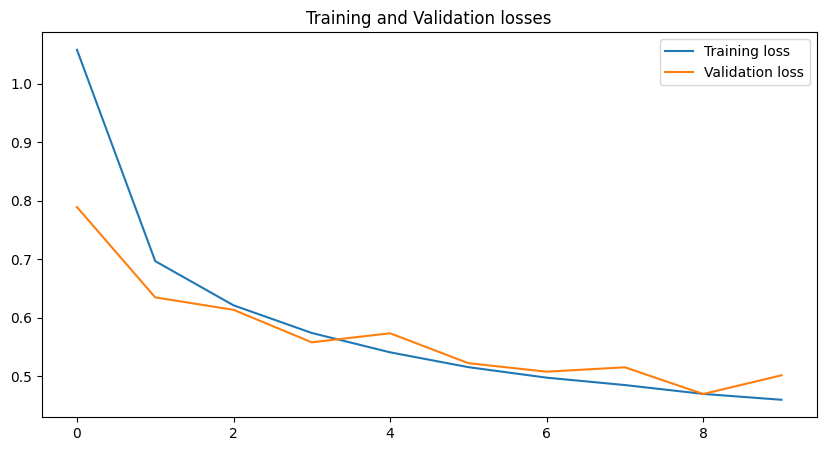

In [238]:
fig = plt.figure(figsize=(10, 5))

plt.plot(np.arange(n_epochs), train_losses, label="Training loss")
plt.plot(np.arange(n_epochs), valid_losses, label="Validation loss")
plt.title("Training and Validation losses")
plt.legend()
plt.show()

## Making predictions

In [239]:
class MyAccuracy(tf.keras.metrics.Metric):
  def __init__(self, num_classes=10, **kwargs):
    super().__init__(**kwargs)
    self.num_classes = num_classes
    self.correct = tf.Variable(0)

  def update_state(self, y_true, y_pred):
    for idx, prediction in enumerate(y_pred):
      if y_true[idx] == prediction:
        self.correct.assign_add(1)

    self.correct = self.correct / len(y_true)

  def result(self):
    return self.correct

  def reset_state(self):
    self.correct = 0

In [240]:
def make_predictions(model, test_features, test_labels, num_classes=10):

  # Make predictions
  y_pred = np.argmax(model.predict(test_features), axis=-1)

  # Use our custom metric to calculate accuracy score
  accuracy_metric = MyAccuracy(num_classes=num_classes)
  accuracy_metric.update_state(y_true=test_labels, y_pred=y_pred)
  accuracy_score = accuracy_metric.result()

  # Print the accuracy score
  print(f"Accuracy score of our model on fashion MNIST dataset: {accuracy_score*100:.4f}%")

  # Reset the metric
  accuracy_metric.reset_state()

  return accuracy_score

In [241]:
accuracy = make_predictions(model, test_set, y_test)

313/313 [==============================] - 1s 2ms/step
Accuracy score of our model on fashion MNIST dataset: 82.7200%


In [242]:
# Check if our custom metric works properly
from sklearn.metrics import accuracy_score

model_pred = model.predict(test_set)
model_pred = np.argmax(model_pred, axis=-1)

accuracy_score(y_test, model_pred)

313/313 [==============================] - 1s 2ms/step


0.8272

## Creating Confusion Matrix to visualize our model predictions

In [243]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9
0,677,1,14,56,21,4,201,0,26,0
1,0,966,1,17,7,1,5,1,2,0
2,11,3,610,12,174,0,185,0,5,0
3,42,11,6,803,42,11,76,2,7,0
4,1,1,15,30,868,0,79,0,6,0
5,0,0,0,0,0,938,0,43,19,0
6,81,3,40,28,152,3,665,0,28,0
7,0,0,0,0,0,24,0,969,1,6
8,0,1,1,1,6,13,17,6,955,0
9,0,1,0,0,0,22,0,154,2,821


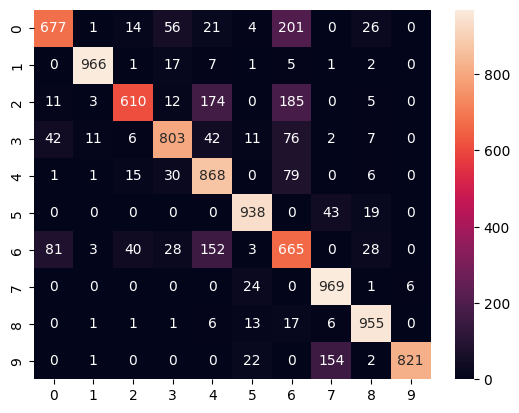

In [245]:
import seaborn as sns

sns.heatmap(data=cm,
            annot=True,
            fmt=".0f",
            cbar=True);